# PepsiCo Data Science Challenge - Crop Quality Assessment

## Introduction

This notebook will contain my solution to the PepsiCo Data Science Challenge 2020. The dataset and objective have been made available on September 25th, 2020, and challengers have until October 7th 2020 to submit their solution. The Grand Prize winner will receive a PepsiCo R&D internship for the summer of 2021. The background and challenge objective are described below, taken directly from https://www.nyas.org/challenges/pepsico-challenge/?utm_source=PepsiCo+Data+Challenge+2020&utm_campaign=f8b6f08078-EMAIL_CAMPAIGN_2020_09_24_08_56&utm_medium=email&utm_term=0_0568b79be0-f8b6f08078-331280438.

Background: Cereal based products rely on raw grain from crops grown by farmers. Different growing locations and environmental conditions are known to influence grain physical and compositional elements which can affect processing and final product quality. The goal of this exercise is to create a model that can predict the effect of growing location, soil type, fertilizer, and crop parameters associated with growth and development on product assessment.

Challenge: A model predicting the assessment score would allow growers to assess product quality. Given the provided data sets, derive a model that would predict the assessment scores as accurately as possible using relevant features or predictor variables.

The following packages and libraries used in this project are imported below:

In [1]:
#import packages that will be used in this project
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In C:\Users\CCCam\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\CCCam\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\CCCam\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\CCCam\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\CCCam\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

## Data Pre-Processing

### Loading Data

The dataset has been downloaded in the form of an excel file with 3 sheets:

1. Crop and Grain Data

2. Weather Data

3. Site Data

We will begin the project by loading the data in to pandas dataframes. The descriptions for each sheet taken directly from the challenge website, along with the code to read each sheet, is shown below:

The Crop and Grain dataset consists of field trials conducted over several years in 5 different locations identified by the Site ID column. Each of the trials had several replicates on which 28 assessment types were measured. Note that the year appended within the Site ID is the harvest year.

The other columns in the dataset are:

- Growth Stage: The crop growth stage on the date that the assessments were conducted; values are ordinal.
- Variety: B and M are the crop varieties grown in the trials.
- Assessment Type: The types of assessments (or KPIs - key performance indicators) measured on the crop.
- Assessment Date: The dates when the assessment types were evaluated.
- Assessment Score: The evaluation scores on each KPI.

In [2]:
#load in dataset
crop_grain_data = pd.read_excel(r'C:\Users\CCCam\OneDrive\DataScience\PepsiCo\nyas-challenge-2020-data.xlsx',sheet_name=0)

#view first few rows of data
crop_grain_data.head()

,ID,Site ID,Growth Stage,Variety,Assessment Date (mm/dd/year),Assessment Type,Assessment Score
0,1,Site E Year 2015,59,M,2015-06-24,C - K,6.2
1,2,Site E Year 2015,75,M,2015-07-10,C - G,2.97283
2,3,Site E Year 2015,87,B,2015-07-25,C - I,71.9144
3,4,Site D Year 2015,87,B,2015-08-06,C - S,95.8586
4,5,Site E Year 2015,59,B,2015-06-15,C - P,450.575


Site metadata are also provided and include:

- Latitude and Elevation of the trial sites
- Sowing and Harvest dates of the trial crops
- Relevant soil parameters and fertilizer quantities; Soil Parameter A has valued at the nominal level.

In [3]:
#load in dataset
site_data = pd.read_excel(r'C:\Users\CCCam\OneDrive\DataScience\PepsiCo\nyas-challenge-2020-data.xlsx',sheet_name=2)

#view first few rows of data
site_data.head()

,Site ID,Latitude,Elevation (m),Sowing Date (mm/dd/year),Harvest Date (mm/dd/year),Soil Parameter A,Soil Parameter B,Amount Fertilizer Applied
0,Site A 2015,52.428385,26.0,2014-10-17,2015-09-01,6,26.9,120.0
1,Site B 2015,52.264336,18.0,2014-10-11,2015-08-12,6,22.6,89.7
2,Site C 2015,54.055351,143.0,2014-10-13,2015-09-06,2,18.9,250.0
3,Site D 2015,56.485340,148.0,2014-09-22,2015-08-28,1,20.0,80.0
4,Site E 2015,51.184087,77.0,2014-09-22,2015-09-04,5,9.6,125.0


Weather data from weather stations installed at each of the trial sites is also included. There are 6 relevant weather parameters in the data. The dates when the data were gathered are included in the weather worksheet.

In [4]:
#load in dataset
weather_data = pd.read_excel(r'C:\Users\CCCam\OneDrive\DataScience\PepsiCo\nyas-challenge-2020-data.xlsx',sheet_name=1)

#view first few rows of data
weather_data.head()

,Site ID,Date (mm/dd/year),Weather Variable A,Weather Variable B,Weather Variable C,Weather Variable D,Weather Variable E,Weather Variable F
0,Site A 2015,2014-10-18,18.7,14.8,0.0,5.4,17.494616,82.0
1,Site A 2015,2014-10-19,16.3,14.6,5.0,5.6,15.550769,79.0
2,Site A 2015,2014-10-20,14.4,11.6,14.6,4.0,9.233269,90.0
3,Site A 2015,2014-10-21,12.3,9.6,0.8,6.6,28.671731,69.0
4,Site A 2015,2014-10-22,14.0,8.2,0.4,3.8,15.064808,72.0


### Merging Dataframes

Now that the data has been loaded in, we will combine the data in to a single dataframe. We will start with the Crop and Grain and Site dataset by merging these two on the Site ID column. The Weather dataset will be revisited during the feature engineering phase, as special precautions will need to be made to extract relevant information that can be combined with other two datasets. 

In [5]:
#remove Year from Site ID in crop_grain_data so it can be merged with site_data
crop_grain_data['Site ID'] = crop_grain_data['Site ID'].apply(lambda x: x.replace(' Year','')).astype(str)

#merge dataframes
df = crop_grain_data.merge(site_data,how='left', on='Site ID')

#show result
df.head()

,ID,Site ID,Growth Stage,Variety,Assessment Date (mm/dd/year),Assessment Type,Assessment Score,Latitude,Elevation (m),Sowing Date (mm/dd/year),Harvest Date (mm/dd/year),Soil Parameter A,Soil Parameter B,Amount Fertilizer Applied
0,1,Site E 2015,59,M,2015-06-24,C - K,6.2,51.184087,77.0,2014-09-22,2015-09-04,5,9.6,125.0
1,2,Site E 2015,75,M,2015-07-10,C - G,2.97283,51.184087,77.0,2014-09-22,2015-09-04,5,9.6,125.0
2,3,Site E 2015,87,B,2015-07-25,C - I,71.9144,51.184087,77.0,2014-09-22,2015-09-04,5,9.6,125.0
3,4,Site D 2015,87,B,2015-08-06,C - S,95.8586,56.485340,148.0,2014-09-22,2015-08-28,1,20.0,80.0
4,5,Site E 2015,59,B,2015-06-15,C - P,450.575,51.184087,77.0,2014-09-22,2015-09-04,5,9.6,125.0


### Data Cleaning

In [6]:
df.replace('*',np.nan,inplace=True)
df['Assessment Score'] = df['Assessment Score'].astype(float)
df['Assessment Score'].dtype

dtype('float64')

## Exploratory Data Analysis

We set the style as 'darkgrid' for our charts.

In [7]:
sns.set_style('darkgrid')

### Variety

There are two categories in the Variety column: B and M. As we can see, the balance between these two varieties are essentially the same - 50.1% for B and 49.9% for M.

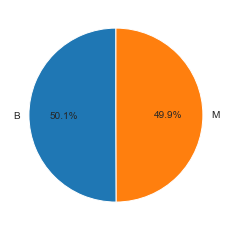

In [8]:
plt.pie(df['Variety'].value_counts(),startangle=90,autopct='%1.1f%%',labels=df['Variety'].value_counts().index)
plt.show()

### Assessment Type

There are over 25 assessment types to base crop scores on. The distribution is heavily imbalanced, with almost one-third of the data being assessed by the C-K type, while the majority of assessment types do not even represent 5% of all crops. It is clear that crop variety is evenly balanced amongst each assessment type.

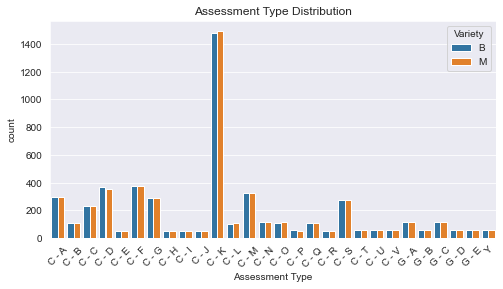

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Assessment Type', order = sorted(df['Assessment Type'].unique()),hue='Variety',hue_order=['B','M'])
plt.xticks(rotation=45)
plt.title('Assessment Type Distribution')
plt.show()

The scales for assessment score vary greatly based on each assessment type. Type C-J scores max out at around .8, while type C-N has some scores over 1,000. For some assessment types, the variety of the crop plays a huge impact on its assessment score, such as C-H, C-I, and G-B. For other assessment types, variety does not have a huge impact on the median score, but influences score spread: C-J, C-L, C-G. While for many, variety does not have a notable effect on the score distributions. These include C-K, C-M, and C-S.

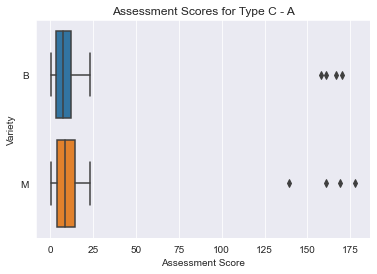

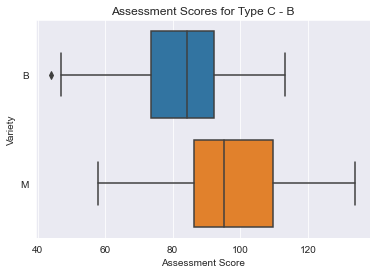

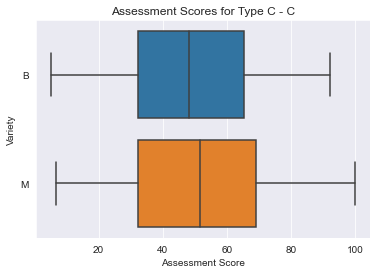

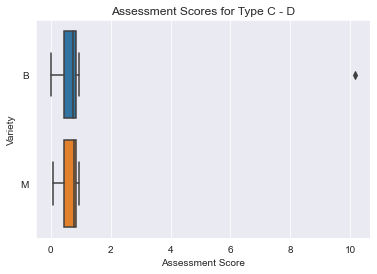

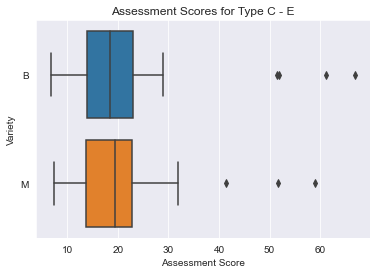

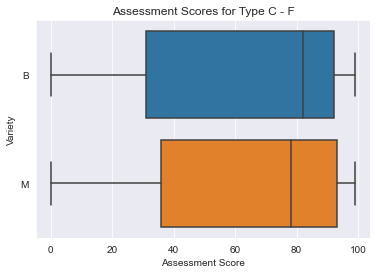

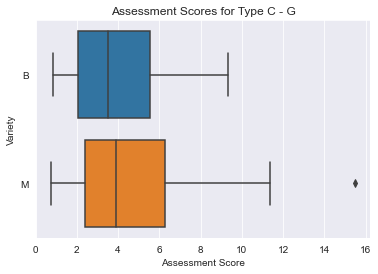

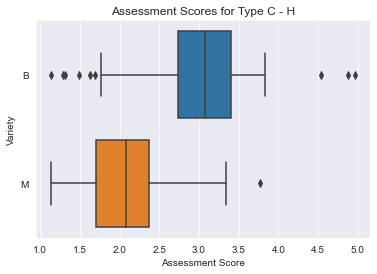

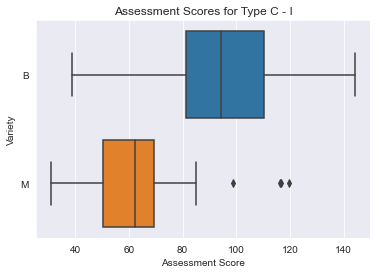

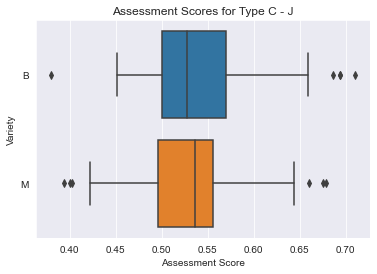

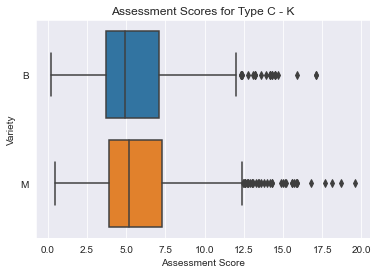

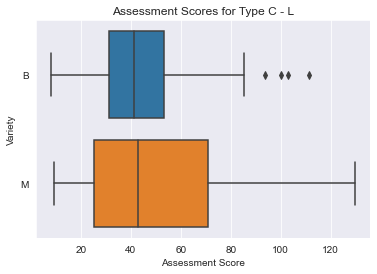

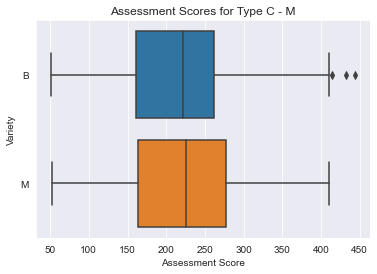

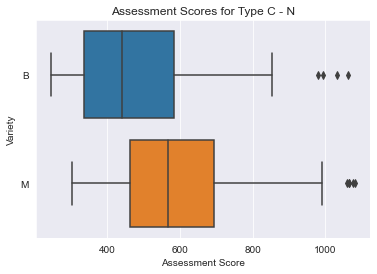

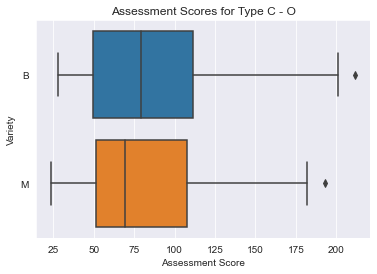

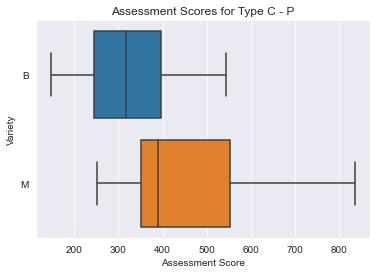

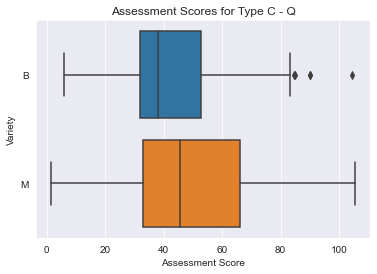

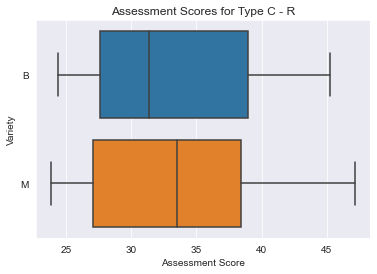

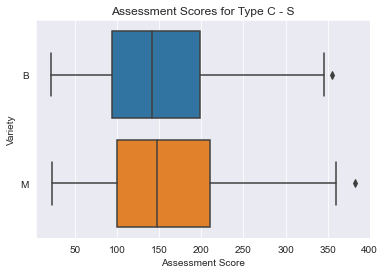

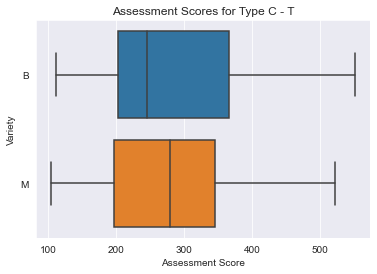

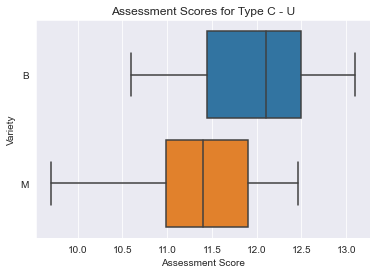

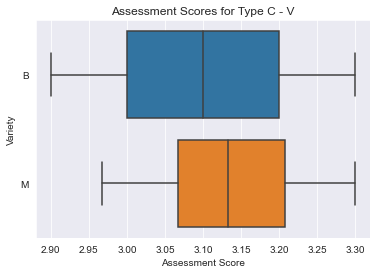

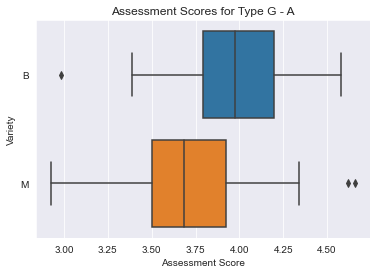

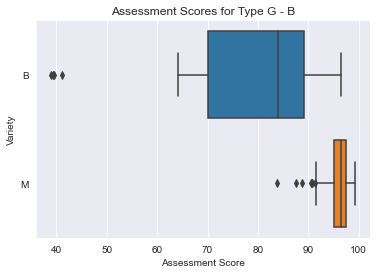

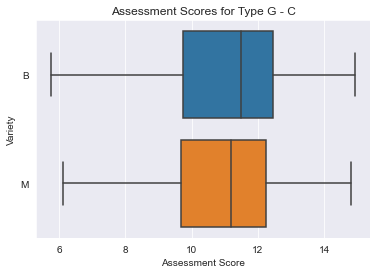

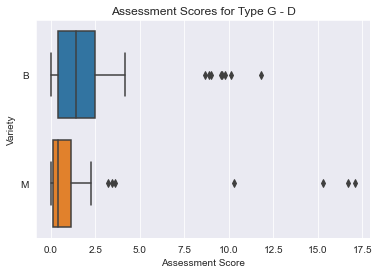

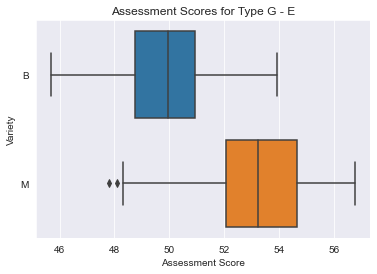

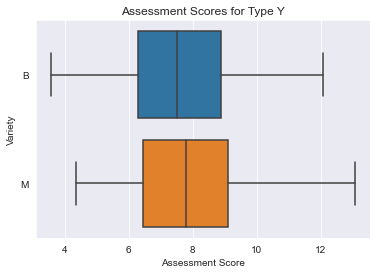

In [10]:
for Type in sorted(df['Assessment Type'].unique()):
    plt.title('Assessment Scores for Type'+' ' +Type)
    sns.boxplot(data=df[df['Assessment Type']==Type],x='Assessment Score',y='Variety',order=['B','M'])
    plt.show()

### Growth Stage

Growth Stage of crops doesn't appear to be normally distributed. There appears to be certain clusters of growth stages, such as between 10-40 and 50-90.

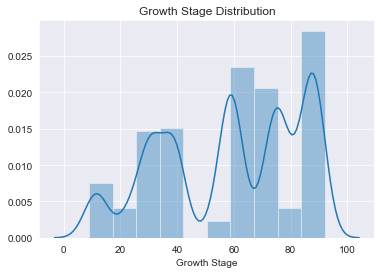

In [11]:
sns.distplot(df['Growth Stage'],bins=10)
plt.title('Growth Stage Distribution')
plt.show()

We can see that Assessment Score is relatively independent of Growth Stage - there doesn't seem to be a clear linear trend between the two variables. We can see that certain ranges of Growth Stages result in poor Assessment Scores. This is shown in approximately the 46-58, 60-73, 75-88 Growth Stage values.

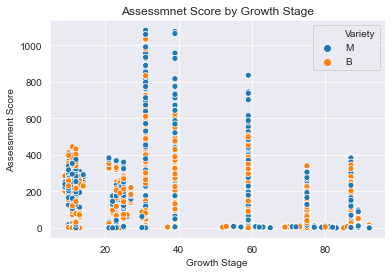

In [12]:
sns.scatterplot(data=df, x='Growth Stage',y='Assessment Score',hue='Variety')
plt.title('Assessmnet Score by Growth Stage')
plt.show()

### Time of Year

The assessment month of crops spans all 12 months and appears to be normally distributed, centered around the month of June. Each variety of crop seems to be evenly represented for each month.

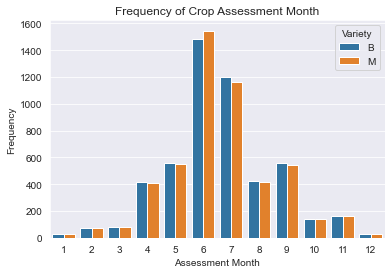

In [13]:
sns.countplot(x=df['Assessment Date (mm/dd/year)'].dt.month,hue=df['Variety'],hue_order=['B','M'])
plt.title('Frequency of Crop Assessment Month')
plt.ylabel('Frequency')
plt.xlabel('Assessment Month')
plt.show()

Assessment Score seems to spike for Assessment Dates that occur during October and November. Interestingly, some of the lowest Assessment Scores occur right before this, during the months of August and September.

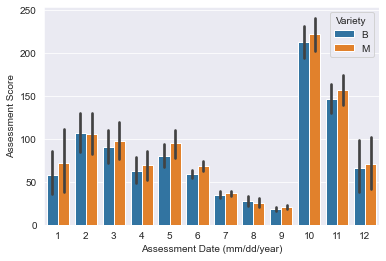

In [14]:
sns.barplot(x=df['Assessment Date (mm/dd/year)'].dt.month,hue=df['Variety'],hue_order=['B','M'],y=df['Assessment Score'])
plt.show()

The sowing month for crops appears to only include September and October, with the latter representing the majority of cases. Again, the crop variety is evenly balanced for both months. 

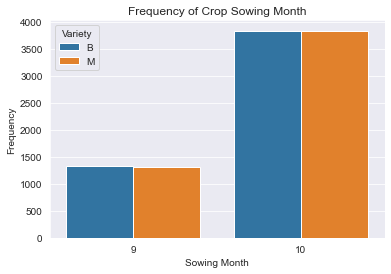

In [15]:
sns.countplot(x=df['Sowing Date (mm/dd/year)'].dt.month,hue=df['Variety'],hue_order=['B','M'])
plt.title('Frequency of Crop Sowing Month')
plt.ylabel('Frequency')
plt.xlabel('Sowing Month')
plt.show()

Crops with Sowing Dates in September seem to be assessed slightly higher than those in October. However, September crops have a larger margin of error. 

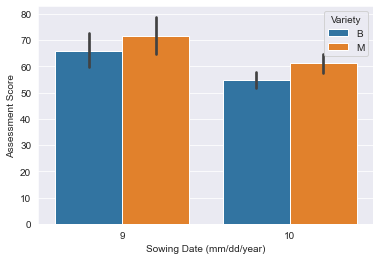

In [16]:
sns.barplot(x=df['Sowing Date (mm/dd/year)'].dt.month,hue=df['Variety'],hue_order=['B','M'],y=df['Assessment Score'])
plt.show()

Harvest months only include August and September, with the former representing the majority of cases. Like the other types of months above, both crop varieties are evenly distributed for each month.

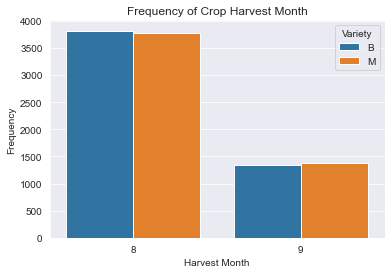

In [17]:
sns.countplot(x=df['Harvest Date (mm/dd/year)'].dt.month,hue=df['Variety'],hue_order=['B','M'])
plt.title('Frequency of Crop Harvest Month')
plt.ylabel('Frequency')
plt.xlabel('Harvest Month')
plt.show()

August harvested crops seem to be assessed slightly lower. Yet, September crops have a larger margin of error.

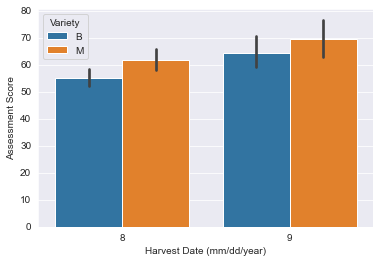

In [18]:
sns.barplot(x=df['Harvest Date (mm/dd/year)'].dt.month,hue=df['Variety'],hue_order=['B','M'],y=df['Assessment Score'])
plt.show()

### Location

There are 5 different sites where crops are planted, and each site has slightly different make ups from year to year. Below we plot the distribution for each site. 

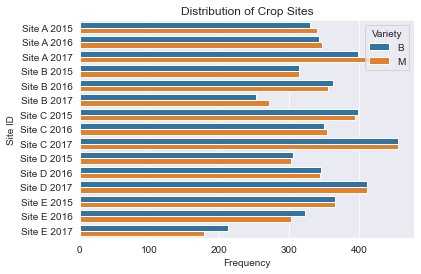

In [19]:
sns.countplot(data=df,y='Site ID',hue='Variety',order = sorted(df['Site ID'].unique()),hue_order=['B','M'])
plt.title('Distribution of Crop Sites')
plt.xlabel('Frequency')
plt.show()

Certain Sites have higher Assessment Scores than others. For instance, Site D consistently ranks below Site B.

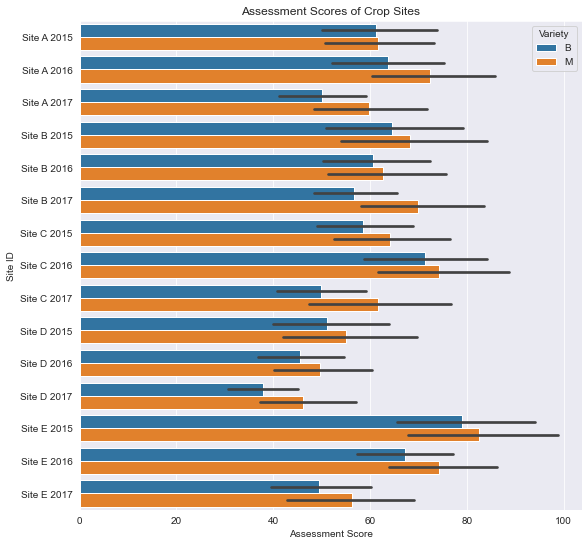

In [20]:
plt.figure(figsize=(9,9))
sns.barplot(data=df,x='Assessment Score',y='Site ID',hue='Variety',order = sorted(df['Site ID'].unique()),hue_order=['B','M'])
plt.title('Assessment Scores of Crop Sites')
plt.xlabel('Assessment Score')
plt.show()

## Data Processing

### Parsing Weather Data

The Weather Data still needs to be integrated in to df. The structure of weather_data will not merge cleanly in to the rest of the data, so we will need to get creative. We will compute various summary statistics for the group of weather reports that occur from the crop's sowing date to harvest date and sowing date to assessment date.

In [21]:
def parseWeather(row):
    
    #filter weather data for crops in matching site and time frame
    assessment_group = weather_data[(weather_data['Date (mm/dd/year)']>=row['Sowing Date (mm/dd/year)'])&(weather_data['Date (mm/dd/year)']<=row['Assessment Date (mm/dd/year)']) & (weather_data['Site ID']==row['Site ID'])]
    harvest_group = weather_data[(weather_data['Date (mm/dd/year)']>=row['Sowing Date (mm/dd/year)'])&(weather_data['Date (mm/dd/year)']<=row['Harvest Date (mm/dd/year)'])& (weather_data['Site ID']==row['Site ID'])]
    
    #loop through each weather variable
    solutions = []
    for char in ['A','B','C','D','E','F']:
        
        #add summary statistics for sow-assessment group
        assessment_var = assessment_group['Weather Variable '+char]
        
        solutions.append(assessment_var.mean())
        solutions.append(assessment_var.std())
        
        solutions.append(assessment_var.min())
        solutions.append(assessment_var.max())
        
        solutions.append(assessment_var.quantile(.25))
        solutions.append(assessment_var.quantile(.50))
        solutions.append(assessment_var.quantile(.75))
                
        #add summary statistics for sow-harvest group
        harvest_var = harvest_group['Weather Variable '+char]
        
        solutions.append(harvest_var.mean())
        solutions.append(harvest_var.std())
        
        solutions.append(harvest_var.min())
        solutions.append(harvest_var.max())
        
        solutions.append(harvest_var.quantile(.25))
        solutions.append(harvest_var.quantile(.50))
        solutions.append(harvest_var.quantile(.75))
        
    if len(solutions)!=84:
        print('issue')
        print(row['ID'])
        
    return solutions

#create set of labels for dataframe columns
labels=[]
for char in ['A','B','C','D','E','F']:
    labels.append(char+'_mean_a')
    labels.append(char+'_std_a')
    labels.append(char+'_min_a')
    labels.append(char+'_max_a')
    labels.append(char+'_25_a')
    labels.append(char+'_50_a')
    labels.append(char+'_75_a')
    labels.append(char+'_mean_h')
    labels.append(char+'_std_h')
    labels.append(char+'_min_h')
    labels.append(char+'_max_h')
    labels.append(char+'_25_h')
    labels.append(char+'_50_h')
    labels.append(char+'_75_h')

#apply function to update dataframe
df[labels] = df.apply(lambda x: pd.Series(parseWeather(x)), axis=1)
df[labels].head()

,A_mean_a,A_std_a,A_min_a,A_max_a,A_25_a,A_50_a,A_75_a,A_mean_h,A_std_h,A_min_h,...,F_25_a,F_50_a,F_75_a,F_mean_h,F_std_h,F_min_h,F_max_h,F_25_h,F_50_h,F_75_h
0,12.527273,4.838466,2.0,24.0,9.000,12.00,17.000,14.242075,5.619862,2.0,...,69.0,78.00,86.00,76.048991,11.193796,46.00,98.0,68.00,76.00,85.000
1,13.116838,5.345971,2.0,31.0,9.000,12.00,17.000,14.242075,5.619862,2.0,...,69.0,77.00,85.50,76.048991,11.193796,46.00,98.0,68.00,76.00,85.000
2,13.506536,5.513764,2.0,31.0,9.000,13.00,18.000,14.242075,5.619862,2.0,...,68.0,77.00,85.00,76.048991,11.193796,46.00,98.0,68.00,76.00,85.000
3,11.941384,4.768804,-0.6,24.0,8.625,11.55,15.975,12.439294,4.997874,-0.6,...,83.3,89.35,94.58,88.253059,6.955861,65.17,99.1,83.26,89.07,94.285
4,12.255639,4.675353,2.0,24.0,9.000,12.00,16.000,14.242075,5.619862,2.0,...,70.0,78.00,86.00,76.048991,11.193796,46.00,98.0,68.00,76.00,85.000


### Feature Engineering

We will begin our feature engineering by calculating the elapsed time between each of the date columns in the dataframe: Sowing Date, Harvest Date, and Assessment Date. It is important to note that some values for Harvest to Assessment are negative as the crop was assessed before it was harvested for these entries.

In [22]:
#calculate time difference between each of the dates 
df['Sow to Assessment']= (df['Assessment Date (mm/dd/year)']-df['Sowing Date (mm/dd/year)']).dt.days
df['Sow to Harvest']= (df['Harvest Date (mm/dd/year)']-df['Sowing Date (mm/dd/year)']).dt.days
df['Harvest to Assessment']= (df['Assessment Date (mm/dd/year)']-df['Harvest Date (mm/dd/year)']).dt.days

df[['Sowing Date (mm/dd/year)','Harvest Date (mm/dd/year)','Assessment Date (mm/dd/year)','Sow to Assessment','Sow to Harvest','Harvest to Assessment']]

,Sowing Date (mm/dd/year),Harvest Date (mm/dd/year),Assessment Date (mm/dd/year),Sow to Assessment,Sow to Harvest,Harvest to Assessment
0,2014-09-22,2015-09-04,2015-06-24,275,347,-72
1,2014-09-22,2015-09-04,2015-07-10,291,347,-56
2,2014-09-22,2015-09-04,2015-07-25,306,347,-41
3,2014-09-22,2015-08-28,2015-08-06,318,340,-22
4,2014-09-22,2015-09-04,2015-06-15,266,347,-81
...,...,...,...,...,...,...
10308,2015-10-02,2016-08-17,2016-08-16,319,320,-1
10309,2015-10-27,2016-08-30,2016-06-21,238,308,-70
10310,2015-10-08,2016-08-24,2016-04-20,195,321,-126
10311,2014-09-22,2015-08-28,2015-08-06,318,340,-22


Next, we will parse just the site name - leaving out the site year - from the Site ID column, and assign it to a new column, Site. This may help the machine learning models generalize for any test data past the year 2017.

In [23]:
#remove year from Site ID and assign it to Site column
df['Site']=df['Site ID'].apply(lambda x: x[:-5])
df[['Site ID','Site']].head()

,Site ID,Site
0,Site E 2015,Site E
1,Site E 2015,Site E
2,Site E 2015,Site E
3,Site D 2015,Site D
4,Site E 2015,Site E


Finally, we will extract relevant information from the date columns, such as year, month, day and weekday. 

In [24]:
#extract sowing date information 
df['Sowing Year']=df['Sowing Date (mm/dd/year)'].dt.year.astype(str)
df['Sowing Month']=df['Sowing Date (mm/dd/year)'].dt.month.astype(str)
df['Sowing Day']=df['Sowing Date (mm/dd/year)'].dt.day.astype(str)
df['Sowing Weekday']=df['Sowing Date (mm/dd/year)'].dt.weekday.astype(str)

#extract harvest date information
df['Harvest Year']=df['Harvest Date (mm/dd/year)'].dt.year.astype(str)
df['Harvest Month']=df['Harvest Date (mm/dd/year)'].dt.month.astype(str)
df['Harvest Day']=df['Harvest Date (mm/dd/year)'].dt.day.astype(str)
df['Harvest Weekday']=df['Harvest Date (mm/dd/year)'].dt.weekday.astype(str)

#extract assessment date information
df['Assessment Year']=df['Assessment Date (mm/dd/year)'].dt.year.astype(str)
df['Assessment Month']=df['Assessment Date (mm/dd/year)'].dt.month.astype(str)
df['Assessment Day']=df['Assessment Date (mm/dd/year)'].dt.day.astype(str)
df['Assessment Weekday']=df['Assessment Date (mm/dd/year)'].dt.weekday.astype(str)

#display new columns
df[['Sowing Date (mm/dd/year)','Harvest Date (mm/dd/year)','Assessment Date (mm/dd/year)','Sowing Year','Sowing Month',
    'Sowing Day','Sowing Weekday','Harvest Year','Harvest Month','Harvest Day','Harvest Weekday','Assessment Year',
    'Assessment Month','Assessment Day','Assessment Weekday']].head()

,Sowing Date (mm/dd/year),Harvest Date (mm/dd/year),Assessment Date (mm/dd/year),Sowing Year,Sowing Month,Sowing Day,Sowing Weekday,Harvest Year,Harvest Month,Harvest Day,Harvest Weekday,Assessment Year,Assessment Month,Assessment Day,Assessment Weekday
0,2014-09-22,2015-09-04,2015-06-24,2014,9,22,0,2015,9,4,4,2015,6,24,2
1,2014-09-22,2015-09-04,2015-07-10,2014,9,22,0,2015,9,4,4,2015,7,10,4
2,2014-09-22,2015-09-04,2015-07-25,2014,9,22,0,2015,9,4,4,2015,7,25,5
3,2014-09-22,2015-08-28,2015-08-06,2014,9,22,0,2015,8,28,4,2015,8,6,3
4,2014-09-22,2015-09-04,2015-06-15,2014,9,22,0,2015,9,4,4,2015,6,15,0


Now that we have extracted all information from the date columns, we will drop these. We do this because datetime objects can not be fit to the machine learning models that will be used.

In [25]:
#drop original date columns
df.drop(columns=['Sowing Date (mm/dd/year)','Harvest Date (mm/dd/year)','Assessment Date (mm/dd/year)'],inplace=True)

### Missing Values

Let's take a look at the missing values in the DataFrame. There are values missing for Assessment Score and many of the weather related columns. All of these columns are missing 16 values, so it is likely the same 16 entries for each. There must have been no weather reports during the life cycle for these crops.

In [26]:
#show column names with missing values and quantity
for column in df.columns[df.isnull().any()]:
    print(column, df[column].isnull().sum())

Assessment Score 14
A_mean_a 16
A_std_a 16
A_min_a 16
A_max_a 16
A_25_a 16
A_50_a 16
A_75_a 16
B_mean_a 16
B_std_a 16
B_min_a 16
B_max_a 16
B_25_a 16
B_50_a 16
B_75_a 16
C_mean_a 16
C_std_a 16
C_min_a 16
C_max_a 16
C_25_a 16
C_50_a 16
C_75_a 16
D_mean_a 16
D_std_a 16
D_min_a 16
D_max_a 16
D_25_a 16
D_50_a 16
D_75_a 16
E_mean_a 16
E_std_a 16
E_min_a 16
E_max_a 16
E_25_a 16
E_50_a 16
E_75_a 16
F_mean_a 16
F_std_a 16
F_min_a 16
F_max_a 16
F_25_a 16
F_50_a 16
F_75_a 16


Now we will impute these missing values. For the weather columns, we will take the mean of each Site ID and Sowing Month group. For Assessment Score we will impute based on mean of Assessment Type. Normally we would not impute for the target label, but the challenge specifies we need a prediction for each row, so we will keep these.

In [27]:
#fill weather columns
for column in df.columns[df.isnull().any()]:
    df[column]=df[column].fillna(df.groupby(['Site ID','Sowing Month'])[column].transform('mean'))

#fill Assessment Score column
df['Assessment Score']=df['Assessment Score'].fillna(df.groupby(['Assessment Type'])['Assessment Score'].transform('mean'))

### Machine Learning Pre-Processing

Now we will need to process the data to be feed in to the machine learning models. Before we alter the dataframe, we will create a benchmark to judge the models against. For this benchmark, we will calculate the MAE for the average assessment score of each assessment type and the actual values. The benchmark achieves a score of 19.5354.

In [28]:
#get average assessment score for each assessment type
solutions = []
def getScores(row):
    group = df[df['Assessment Type']==row['Assessment Type']]
    score = group['Assessment Score'].mean()
    solutions.append(score)

df.apply(lambda x: getScores(x),axis=1)

#show benchmark score 
print('Benchmark:',MAE(pd.Series(solutions),df['Assessment Score']))

Benchmark: 19.53543979490134


To prepare our data for machine learning, we will need to dummy the categorical columns and standardize the continuous columns. 

In [29]:
#dummy columns
categorical=['Site ID','Variety','Assessment Type','Site','Sowing Year','Sowing Month','Sowing Weekday',
             'Harvest Year','Harvest Month','Harvest Weekday','Assessment Year','Assessment Month','Assessment Weekday']

dummies = pd.get_dummies(df[categorical])
df.drop(columns=categorical,inplace=True)
df = pd.concat([df,dummies],axis=1)

#scale columns
continuous = labels + ['Growth Stage','Latitude','Elevation (m)','Soil Parameter A','Soil Parameter B','Amount Fertilizer Applied','Sowing Day','Harvest Day','Assessment Day']
df[continuous] = scale(df[continuous])

#show shape of new dataframe
df.shape

(10313, 193)

Now that our data is ready to go, we will split it into a train and test set to evaluate the machine learning models. 20% of the data will be used to create the test set. 

In [30]:
#seperate features and target label
X = df.drop(columns=['Assessment Score','ID'])
y = df['Assessment Score']

#split in to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

## Model Building

### Lasso

We will begin the model building phase with Lasso Regression. This is a type of linear regression, which performs well on sparse datasets like this one. We will GridSearchCV with 10 folds to tune the alpha parameter. After the model has been fitted and made its predictions, we will calculate the MAE on the train set and test set. On the train set, the model scores an MAE of 21.59, and on the test set, the model scores an MAE of 22.00. The benchmark had an MAE of 19.54, so Lasso Regression doesn't seem to be a good model for this task. 

In [31]:
#create GridSearchCV object with KNeighborsClassifier as estimator
param_grid = {'alpha': [.001,.01,.1,1,10,100]}
LaR = GridSearchCV(Lasso(max_iter=100000), n_jobs=-1, cv=10, param_grid=param_grid)

#fit on train data
LaR.fit(X_train, y_train)

#predict on train and test data
train_pred = LaR.predict(X_train)
test_pred = LaR.predict(X_test)

#display score 
print('Train Error', MAE(train_pred,y_train))
print('Test Error', MAE(test_pred,y_test))

Train Error 21.59113679571712
Test Error 22.004414446315366


In [32]:
LaR.best_params_

{'alpha': 0.001}

### K-Neighbors

Next, we have K-Neighbor Regression. We will use GridSearchCV to to tune the n_neighbors, weights, and p parameter. This model scores an MAE of 4.22 on the train set, and an MAE of 6.07 on the test set. This performance is significantly better than Lasso and the benchmark. K-Neighbors seems to be an appropriate model for this task.

In [33]:
#create GridSearchCV object with KNeighborsClassifier as estimator
param_grid = {'n_neighbors':np.arange(1,30),'weights':['distance','uniform'],'p':[1,2]}
KNR = GridSearchCV(KNeighborsRegressor(), n_jobs=-1, cv=10, param_grid=param_grid)

#fit on train data
KNR.fit(X_train, y_train)

#predict on train and test data
train_pred = KNR.predict(X_train)
test_pred = KNR.predict(X_test)

#display score 
print('Train Error', MAE(train_pred,y_train))
print('Test Error', MAE(test_pred,y_test))

Train Error 4.218030988746457
Test Error 6.074867778973696


In [34]:
KNR.best_params_

{'n_neighbors': 11, 'p': 1, 'weights': 'distance'}

### Random Forest

Now, we will use Random Forest Regression. We will use GridSearchCV to tune the max_depth and min_samples_leaf parameter. This model scores an MAE of 4.27 on the train set, and an MAE of 6.03 on the test set. This model performs slightly worse on the train set, but slightly better on the test set than K-Neighbors, meaning that this model is better able to generalize.

In [35]:
#set paramater list
param_grid = {'max_depth':[1,2,4,8,16,32,64,128],'min_samples_leaf':[1,2,4,8]}

#fit GridSearchCV
RFR = GridSearchCV(RandomForestRegressor(random_state=0,max_features='auto'),n_jobs=-1,scoring='neg_mean_absolute_error',cv=10, param_grid=param_grid)
RFR.fit(X_train,y_train)

#use model to predict values
train_pred = RFR.predict(X_train)
test_pred = RFR.predict(X_test)

#display score 
print('Train Error', MAE(train_pred,y_train))
print('Test Error', MAE(test_pred,y_test))

Train Error 4.272656454977773
Test Error 6.025298670949492


In [36]:
RFR.best_params_

{'max_depth': 64, 'min_samples_leaf': 1}

### Support Vector

Finally we have Support Vector Regression. We will use GridSearchCV to find the optimal kernel and C value. The chosen kernel is linear, making this model perform similar to Lasso Regression. This model scores 24.33 on the train set and 25.55 on the test set. Like Lasso, this does not seem to be an appropriate model for this task either.

In [37]:
#set paramater list
param_grid = {'kernel':['linear','poly', 'rbf', 'sigmoid'],'C':[.001,.01,.1,1,10,100,1000]}

#fit GridSearchCV
SV = GridSearchCV(SVR(),n_jobs=-1,scoring='neg_mean_absolute_error',cv=10, param_grid=param_grid)
SV.fit(X_train,y_train)

#use model to predict values
train_pred = SV.predict(X_train)
test_pred = SV.predict(X_test)

#display score 
print('Train Error', MAE(train_pred,y_train))
print('Test Error', MAE(test_pred,y_test))

Train Error 24.333309037530032
Test Error 24.545008657888157


In [38]:
SV.best_params_

{'C': 1, 'kernel': 'linear'}

## Conclusion

The best model for this task seems to be Random Forest Regression. The GridSearchCV choose a very large value for max_depth (64), yet despite this, the model was still able to avoid over fitting to the train set. Now, let's fit an instance of the model over the entire dataset. We get an overall MAE of 2.31, significantly better than the benchmark score of 19.54.

In [39]:
#fit model over entire dataset
RFR = RandomForestRegressor(random_state=0, max_features='auto', max_depth=64)
RFR.fit(X, y)

#predict for entire dataset
all_pred = RFR.predict(X)

#show overall MAE
print('Overall Error', MAE(all_pred,y))

Overall Error 4.3758950008944035


Finally, let's examine which features were most influential in predicting assessment score. Clearly, assessment type played the largest impact on the assessment score of the crop. This makes sense as each type seems to have a different scale for scoring the crop. Interestingly, Assessment Day played a large impact. Other than that, the weather related features appeared to be very important as well.

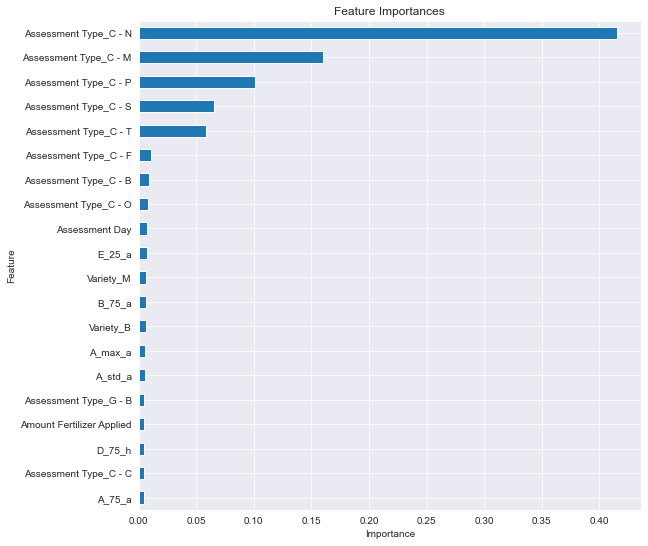

In [40]:
#chart feature importances
feature_importances = pd.Series(RFR.feature_importances_,index = X.columns)
plt.figure(figsize=(9,9))
feature_importances.sort_values()[-20:].plot(kind='barh')
plt.title('Feature Importances')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

Finally, we will compile the final results in to an excel file.

In [41]:
#put final results in dataframe
final =pd.DataFrame(all_pred)
final.to_excel('answers.xlsx')